# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

This project implements a software pipeline to detect vehicles in a video.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
import numpy as np
from sklearn import svm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm
import time

%matplotlib inline

np.random.seed(12061979) # make random number generation repeatable

## Image Plotting

In [6]:
import itertools
import math

def plot_images_grid(images, cmap=None, labels=[]):
    plt.axis('off')
    grid_cols = 2 if len(images) >=2 else 1
    
    grid_rows = math.ceil(len(images)/float(grid_cols))
    fig_height_inches = (16/grid_cols)*grid_rows
    fig, axes = plt.subplots(len(images), grid_cols, figsize=(16, fig_height_inches))
    fig.subplots_adjust(wspace=0.001, hspace=0.2)

    for ax, image, label in itertools.zip_longest(axes.ravel(), images, labels):
        if image is not None:
            ax.imshow(image, cmap=cmap)
            if label is not None:
                ax.set_title(label)
        ax.axis('off')
    
def plot_image(img):
    plt.imshow(img, cmap='gray')

## Load Training Data Set
Data set images are loaded into memory in order to speed up feature extraction necessary for
e.g. hog parameter exploration.

In [10]:
vehicle_img_files = glob.glob('training_dataset/vehicles/**/*.png')
nonvehicle_img_files = glob.glob('training_dataset/non-vehicles/**/*.png')
print("vehicles: " + str(len(vehicle_img_files)), ", non vehicles: " + str(len(nonvehicle_img_files)))

def load_img(file):
    return mpimg.imread(file)

vehicle_imgs = [load_img(file) for file in tqdm(vehicle_img_files)]
nonvehicle_imgs = [load_img(file) for file in tqdm(nonvehicle_img_files)]

vehicles: 8792 , non vehicles: 8968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:10<00:00, 873.65it/s]


## Show Training Data Set Samples

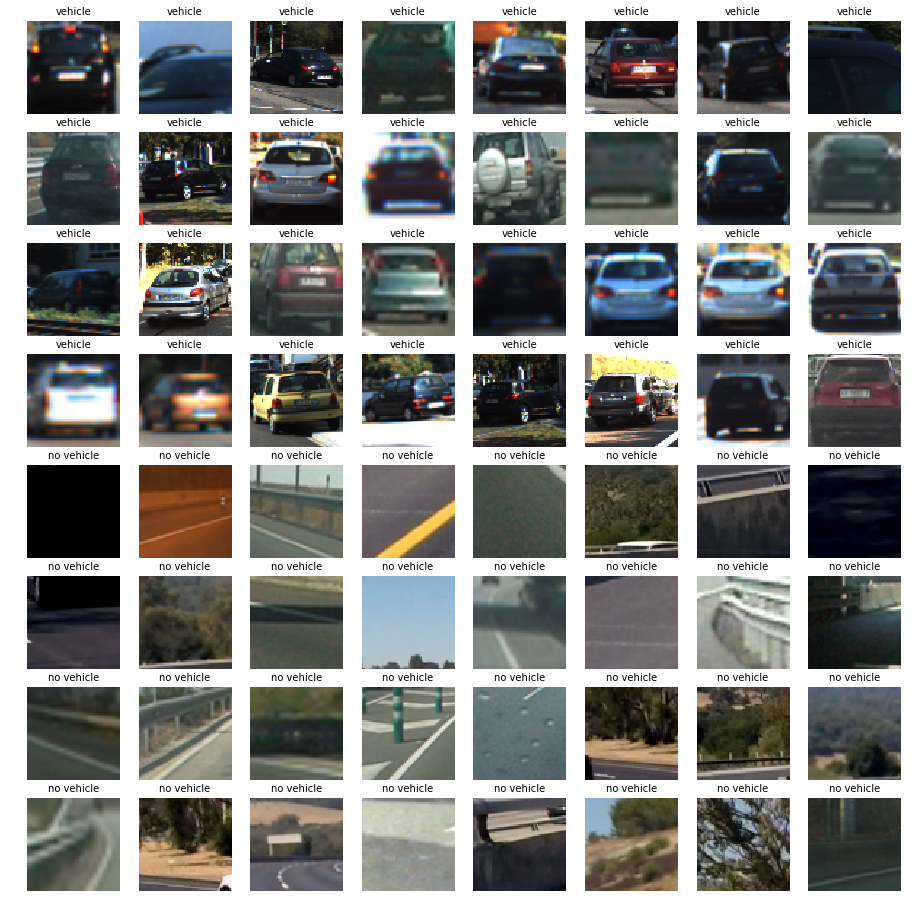

In [12]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# TODO change code
# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = vehicle_imgs[np.random.randint(0,len(vehicle_imgs))]
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = nonvehicle_imgs[np.random.randint(0,len(nonvehicle_imgs))]
    axs[i].axis('off')
    axs[i].set_title('no vehicle', fontsize=10)
    axs[i].imshow(img)

## HOG Feature Extraction

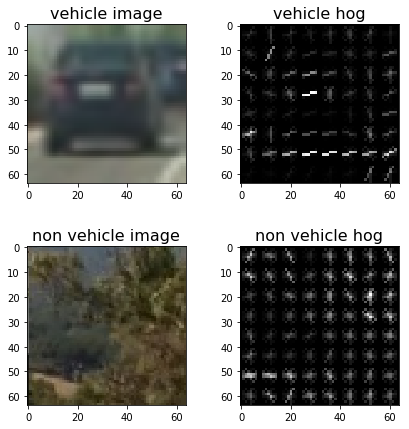

In [13]:
from skimage.feature import hog

def hog_features(img, orientation, pixels_per_cell, cells_per_block, visualise):
    features, hog_image = hog(
        img, 
        orientations=orientation, 
        pixels_per_cell=(pixels_per_cell, pixels_per_cell),
        cells_per_block=(cells_per_block, cells_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=True)
    return features, hog_image

# TODO: Change code
# TODO why '2' in third dimension of array?
# TODO what is '9' in terms of orientation?
vehicle_img = vehicle_imgs[0]
_, vehicle_hog = hog_features(vehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                              cells_per_block=8, visualise=True)

nonvehicle_img = nonvehicle_imgs[1]
_, nonvehicle_hog = hog_features(nonvehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                                 cells_per_block=8, visualise=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('vehicle image', fontsize=16)
ax2.imshow(vehicle_hog, cmap='gray')
ax2.set_title('vehicle hog', fontsize=16)
ax3.imshow(nonvehicle_img)
ax3.set_title('non vehicle image', fontsize=16)
ax4.imshow(nonvehicle_hog, cmap='gray')
ax4.set_title('non vehicle hog', fontsize=16)


## HOG for Training Data Set

In [14]:
def features_for_images(imgs, color_space, orientation,  pixels_per_cell, cells_per_block, channels):
    imgs_features = []
    for img in imgs:
        img_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        for channel in channels:
            channel_features = hog(
                img[:,:,channel], 
                orientations=orientation, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, 
                visualise=False, 
                feature_vector=True)
            img_features.append(channel_features
                               )
        img_features = np.ravel(img_features)        
        imgs_features.append(img_features)
    
    return imgs_features

In [15]:
def build_dataset(color_space, orientation, pixels_per_cell, cells_per_block, channels):
    vehicles_features = features_for_images(
        vehicle_imgs, color_space=color_space, orientation=orientation, 
        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channels=channels)
    nonvehicles_features = features_for_images(
        nonvehicle_imgs, color_space=color_space, orientation=orientation, 
        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channels=channels)

    X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))
    
    return X, y

## Parameter Exploration for SVM Training

In [16]:
def train_svm(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc, svc.score(X_test, y_test)
    

In [18]:
# TODO remove channel_variations = [[0], [1], [2], [0,1,2]]
color_channel_variations = (
    #('HSV', [2]),
    #('HSV', [0,1,2]),
    #('HLS', [2]),
    ('HLS', [0,1,2]))
    #('YUV', [0]),
    #('YUV', [0,1,2]),
    #('YCrCb', [0]),
    #('YCrCb', [0,1,2]))
cells_variations = [2]
pixels_variations = [8] # (6,7,8,9)
orientation_variations = [9]

# TODO improve: use pandas data frame to add results and then sort by svm accuracy
# TODO: make easily runnable for reviewer (not full parameter exploration)

count = 0
rand_state = 33
for color_channel in color_channel_variations:
    color_space = color_channel[0]
    channels = color_channel[1]
    for orientation in orientation_variations:
        for cells_per_block in cells_variations:
            for pixels_per_cell in pixels_variations:
                count += 1

                t_start = time.time()
                X, y = build_dataset(
                    color_space=color_space, 
                    orientation=orientation,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    channels=channels)
                t_feature_extraction = time.time() - t_start

                # split into train and test set
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=rand_state)

                t_train_start = time.time()
                _, score = train_svm(X_train, y_train, X_test, y_test)
                t_training = time.time() - t_train_start

                print("score=" + "{0:.2f}".format(score) + " for orientation=" + str(orientation) + 
                      ", color space=" + color_space +
                      ", channels=" + str(channels) +
                      ", pixels per cell=" + str(pixels_per_cell) + 
                      ", cells per block=" + str(cells_per_block) + 
                     " in " + "{0:.1f}".format(t_feature_extraction) + " secs feature extraction and " + 
                     "{0:.1f}".format(t_training) + " secs training")

print("combinations tested " + str(count))

C:\bigdata\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

|  No. |  Accuracy | Orientations | Color Space  | Channels  | Pixels per Cell  | Cells per Block | Time Feature Extraction | Time Training |
|---|---|---|---|---|---|---|
|  1 |  0.96 | 9  | HSV  |  2 | 8  | 2  | 22.5 | 5.2 |
|  2 |  0.98 | 9  | HSV  |  0,1,2 | 8  | 2  | 131.7 | 9 |
|  3 |  0.91 | 9  | HLS  |  2 | 8  | 2  | 39.6 | 7.2 |
|  4 |  TBD | 9  | HLS  |  0,1,2 | 8  | 2  | TBD | TBD |
|  5 |  0.96 | 9  | YUV  |  0 | 8  | 2  | 36.6 | 5.1 |
|  6 |  0.98 | 9  | YUV  |  0 | 8  | 0,1,2  | 112.4 | 8.3 |
|  7 |  0.96 | 9  | YCrCb  |  0 | 8  | 0  | 35.6 | 5.1 |
|  8 |  0.98 | 9  | YCrCb  |  0 | 8  | 0,1,2  | 114.8 | 8.6 |

## Train Linear SVM with chosen feature extraction parameters 
The parameters for hog feature extraction are chosen from the parameter exploration above based on a good combination of accuracy and feature extraction time. The feature extraction time is mainly driven by the number of color space channels to include. Thus I chose a parameter combination using the single channel 'V' from 'HSV' color space.

In [19]:
X, y = build_dataset(
    color_space='HSV', 
    orientation=9, 
    pixels_per_cell=8, 
    cells_per_block=2, 
    channels=[2])
print(len(X))

17760


In [20]:
# split data set into train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))

In [21]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.95 Seconds to train SVC...
Test Accuracy of SVC =  0.962
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.]
0.036 Seconds to predict 10 labels with SVC


## Load Test Images

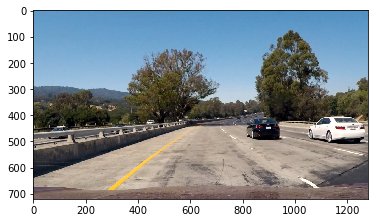

In [25]:
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_test = []
for img_file in image_files:
    imgs_test.append(mpimg.imread(img_file))

plt.imshow(imgs_test[0])

## Sliding Windows

In [27]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [28]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

TypeError: Invalid dimensions for image data

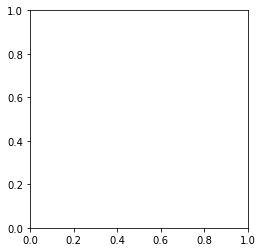

In [31]:
windows = slide_window(imgs_test[0], x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(imgs_test, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Search Vehicles in Windows

In [ ]:
def find_vehicles(img):
    # TODO use windows of different sizes windows 
    pass